<a href="https://colab.research.google.com/github/nerudesu/anitag/blob/master/AniTag.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
os.getcwd()

'/content'

In [0]:
path = os.getcwd() + "/drive/My Drive/Colab Notebooks/projects/AnimeTag"
os.chdir(path)
print("Directory changed to ", path)

Directory changed to  /content/drive/My Drive/Colab Notebooks/projects/AnimeTag


Load the model

In [0]:
import torch
model = torch.hub.load('RF5/danbooru-pretrained', 'resnet50')
model.eval()

Downloading: "https://github.com/RF5/danbooru-pretrained/archive/master.zip" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/RF5/danbooru-pretrained/releases/download/v0.1/resnet50-13306192.pth" to /root/.cache/torch/checkpoints/resnet50-13306192.pth
100%|██████████| 110M/110M [00:04<00:00, 25.1MB/s]


Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256

In [0]:
from PIL import Image
import torch
from torchvision import transforms
input_image = Image.open("img/imas.jpg") # load an image of your choice
preprocess = transforms.Compose([
    transforms.Resize(360),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.7137, 0.6628, 0.6519], std=[0.2970, 0.3017, 0.2979]),
])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

with torch.no_grad():
    output = model(input_batch)

# The output has unnormalized scores. To get probabilities, you can run a sigmoid on it.
probs = torch.sigmoid(output[0]) # Tensor of shape 6000, with confidence scores over Danbooru's top 6000 tags

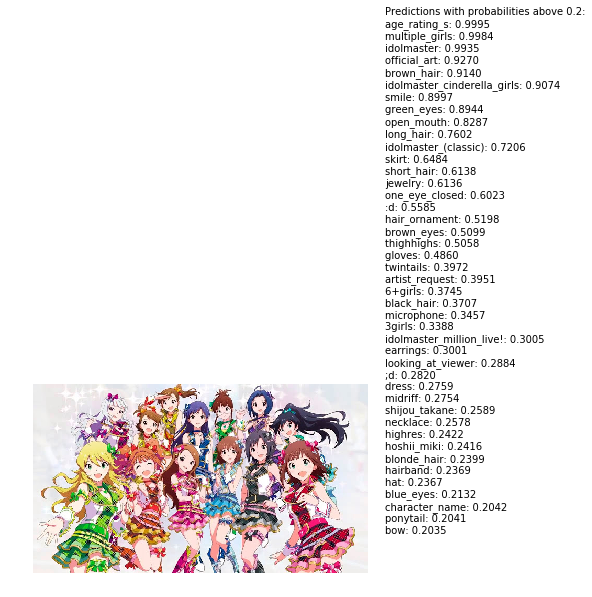

In [0]:
import matplotlib.pyplot as plt
import json
import urllib, urllib.request
# Get class names
with urllib.request.urlopen("https://github.com/RF5/danbooru-pretrained/raw/master/config/class_names_6000.json") as url:
    class_names = json.loads(url.read().decode())
# Plot image
plt.imshow(input_image)
plt.grid(False)
plt.axis('off')

def plot_text(thresh=0.2):
    tmp = probs[probs > thresh]
    inds = probs.argsort(descending=True)
    txt = 'Predictions with probabilities above ' + str(thresh) + ':\n'
    for i in inds[0:len(tmp)]:
        txt += class_names[i] + ': {:.4f} \n'.format(probs[i].cpu().numpy())
    plt.text(input_image.size[0]*1.05, input_image.size[1]*0.85, txt)

plot_text()
# plt.tight_layout()
plt.show()